In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import hvplot.xarray  # noqa
import seaborn as sns
from dask import delayed, compute
import itertools
from pytmatrix import tmatrix_aux, refractive, tmatrix, radar
from pymiecoated import Mie
from scipy.constants import c
from scipy import stats as ss
from sqlalchemy.exc import OperationalError
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask.dataframe as dd
from dask import delayed, compute
from metpy.calc import pressure_to_height_std as p2h
from metpy.calc import lcl
import cartopy.crs as ccrs
import cartopy
import cartopy.mpl.ticker as cticker
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import warnings
warnings.filterwarnings('ignore')



sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask/dataframe/backends.py:181: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Floa

In [2]:
def bcksct(ds, instrument, ar=1, j=0) -> pd.DataFrame:
    """

    :param ds: numpy array of particle diameters. should be in millimeters
    :param ar: axis ratio of the particle
    :param j: Zenith angle input
    :return:
    """
    x_ku = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ku
    x_ka = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_Ka
    x_w = 2 * np.pi * (ds / 2.) / tmatrix_aux.wl_W
    # Tmatrix calculations
    tmat_ku = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ku,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ku], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_ka = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_Ka,
                                                   m=refractive.m_w_0C[tmatrix_aux.wl_Ka], axis_ratio=1.0 / ar, thet0=j,
                                                   thet=180 - j,
                                                   phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
               i in ds]
    tmat_w = [radar.radar_xsect(tmatrix.Scatterer(radius=i / 2., wavelength=tmatrix_aux.wl_W,
                                                  m=refractive.m_w_0C[tmatrix_aux.wl_W], axis_ratio=1.0 / ar, thet0=j,
                                                  thet=180 - j,
                                                  phi0=0., phi=180., radius_type=tmatrix.Scatterer.RADIUS_MAXIMUM)) for
              i in ds]

    # Mie calculations
    mie_ku = [Mie(x=x_ku[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ku]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_ka = [Mie(x=x_ka[w], m=refractive.m_w_0C[tmatrix_aux.wl_Ka]).qb() * np.pi * (i / 2.) ** 2 for w, i in
              enumerate(ds)]
    mie_w = [Mie(x=x_w[w], m=refractive.m_w_0C[tmatrix_aux.wl_W]).qb() * np.pi * (i / 2.) ** 2 for w, i in
             enumerate(ds)]
    df_scatter = pd.DataFrame(
        {'T_mat_Ku': tmat_ku, 'T_mat_Ka': tmat_ka, 'T_mat_W': tmat_w, 'Mie_Ku': mie_ku, 'Mie_Ka': mie_ka,
         'Mie_W': mie_w}, index=ds)
    path_db = f'{path_data}/db'
    str_db = f"sqlite:///{path_db}/backscatter.sqlite"
    df_scatter.to_sql(f'{instrument}', con=str_db, if_exists='replace')
    return df_scatter


def ref_calc(xr_data, mie=False):
    ds = xr_data.diameter.values / 1e3
    try:
        path_db = f'{path_data}/db'
        make_dir(path_db)
        str_db = f"sqlite:///{path_db}/backscatter.sqlite"
        backscatter = pd.read_sql(f"{xr_data.attrs['instrument']}", con=str_db)
    except OperationalError:
        backscatter = bcksct(ds, xr_data.attrs['instrument'])
        
    if len(ds) != backscatter.shape[0]:
        backscatter = bcksct(ds, xr_data.attrs['instrument'])

    ku_wvl = c / 14e9 * 1000
    ka_wvl = c / 35e9 * 1000
    w_wvl = c / 95e9 * 1000
    bcks = xr.Dataset.from_dataframe(backscatter).rename_dims({'index': 'diameter'}).rename({'index': 'diameter'})

    if mie:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ku * xr_data.psd * 1e6 * xr_data.d_d
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_Ka * xr_data.psd * 1e6 * xr_data.d_d
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.Mie_W * xr_data.psd * 1e6 * xr_data.d_d
    else:
        z_ku = (ku_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ku * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_ka = (ka_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_Ka * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        z_w = (w_wvl ** 4 / (np.pi ** 5 * 0.93)) * bcks.T_mat_W * xr_data.psd * 1e6 * xr_data.d_d / 1e3
        
    xr_data['z_ka'] = z_ka
    xr_data['dbz_ka'] = 10 * np.log10(z_ka)
    xr_data['dbz_t_ka'] = 10 * np.log10(z_ka.sum('diameter'))
    xr_data['z_ku'] = z_ku
    xr_data['dbz_ku'] = 10 * np.log10(z_ku)
    xr_data['dbz_t_ku'] = 10 * np.log10(z_ku.sum('diameter'))
    xr_data['z_w'] = z_w
    xr_data['dbz_w'] = 10 * np.log10(z_w)
    xr_data['dbz_t_w'] = 10 * np.log10(z_w.sum('diameter'))
    return xr_data

def pds_parameters(xr_data):
    """
    Compute the psd parameters
    :param xr_data: partice size distribution in # L-1 um-1
    :return: list with lwc, dm, nw, z, and r
    """
    lwc = (np.pi / (6 * 1000.)) * (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * (xr_data.d_d * 1e-3)
    m4 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 4 * xr_data.d_d * 1e-3
    m3 = (xr_data.psd * 1e6) * (xr_data.diameter * 1e-3) ** 3 * xr_data.d_d * 1e-3
    dm = m4.sum('diameter') / m3.sum('diameter')
    z = xr_data.psd * 1e6 * (xr_data.diameter * 1e-3) ** 6 * xr_data.d_d
    nw = 1e3 * (4 ** 4 / np.pi) * (lwc.sum('diameter') / dm ** 4)
    xr_data['lwc'] = lwc
    xr_data['lwc_cum'] = lwc.sum('diameter')
    xr_data['dm'] = dm
    xr_data['z'] = z
    xr_data['dbz'] = 10 * np.log10(xr_data.z)
    xr_data['dbz_t'] = 10 * np.log10(xr_data.z.sum('diameter'))
    xr_data['nw'] = nw
    xr_data['log10_nw'] = np.log10(xr_data.nw)
    xr_data = ref_calc(xr_data)
    xr_data = xr_data.where(xr_data.lwc_cum < 15)
    return xr_data

def add_colorbar_outside(im, ax, label):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.01
    eps = 0.06 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax, label=label)
    
    
def get_eventst(ds, time_lenght=30, time_break=30, tot_counts=10):
    """
    param ds: Xarray dataset with count bin (cnt_bin) matrix
    param time_lenght: Minimum duration of the event
    param time_break: Maximum duration of a time break between events
    param tot_counts: Minimum total number of particles within the count bin spectra
    """
    ev = ds.cnt_bin.sum('diameter').where(ds.cnt_bin.sum('diameter') > tot_counts)
    ev = ev[ev.notnull()]
    a = ev.time.diff('time').to_dataframe('date') 
    sec = pd.Timedelta('30S') 
    breaks = a >= sec
    groups = breaks.cumsum()
    start = [i[1].index.min() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    end = [i[1].index.max() for i in groups.groupby('date') if i[1].shape[0] > time_lenght]
    return start, end

In [3]:
cdict = {'red': ((0., 1, 1),
                 (0.05, 1, 1),
                 (0.11, 0, 0),
                 (0.66, 1, 1),
                 (0.89, 1, 1),
                 (1, 0.5, 0.5)),
         'green': ((0., 1, 1),
                   (0.05, 1, 1),
                   (0.11, 0, 0),
                   (0.375, 1, 1),
                   (0.64, 1, 1),
                   (0.91, 0, 0),
                   (1, 0, 0)),
         'blue': ((0., 1, 1),
                  (0.05, 1, 1),
                  (0.11, 1, 1),
                  (0.34, 1, 1),
                  (0.65, 0, 0),
                  (1, 0, 0))}

my_cmap = LinearSegmentedColormap('my_colormap', cdict, 256)

In [4]:
cluster = SLURMCluster(queue="seseml",
                       memory='20GB',
                       cores=40,
                       processes=1,
                       walltime='24:00:00',
                       scheduler_options={'host': '172.22.179.3:7223', 'dashboard_address': ':7799'})

cluster.scale(jobs=4)
cluster

In [5]:
client = Client(cluster)
client

<Client: 'tcp://172.22.179.3:7223' processes=0 threads=0, memory=0 B>

In [6]:
%%bash
squeue -u $USER

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1379153    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1379152    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1379151    seseml dask-wor alfonso8 PD       0:00      1 (None)
           1379150    seseml dask-wor alfonso8 PD       0:00      1 (None)


In [7]:
aircraft = 'P3B'
aircraft2 = 'P3B'

In [8]:
store3 = f"{path_data}/cloud_probes/zarr/2DS10_{aircraft2}.zarr"
store4 = f"{path_data}/cloud_probes/zarr/HVPS_{aircraft2}.zarr"
store5 = f"{path_data}/cloud_probes/zarr/Page0_Learjet.zarr"
store6 = f"{path_data}/cloud_probes/zarr/FFSSP_{aircraft2}.zarr"
store7 = f"{path_data}/cloud_probes/zarr/FCDP_{aircraft2}.zarr"
store8 = f"{path_data}/cloud_probes/zarr/combined_psd_{aircraft}_300_1000.zarr"


In [9]:
xr_add = xr.open_zarr(store5)#.resample(time='5S').mean()

# Selecting data where temperature is above 2C
times = xr_add.time.where(xr_add.Temp >= 2).dropna('time')

In [10]:
xr_2ds = xr.open_zarr(store3)
# xr_2ds = xr_2ds.where(xr_2ds.time == times)

xr_hvps = xr.open_zarr(store4)
# xr_hvps = xr_hvps.where(xr_hvps.time == times)

xr_fcdp = xr.open_zarr(store7)
# xr_fcdp = xr_fcdp.where(xr_fcdp.time == times)

xr_comb_350  = xr.open_zarr(store8).sel(diameter=slice(40, 3000))
# xr_comb_350  = xr_comb_350.where(xr_comb_350.time == times)
xr_comb_350.attrs['instrument'] = 'combined_psd_2ds_hvps'

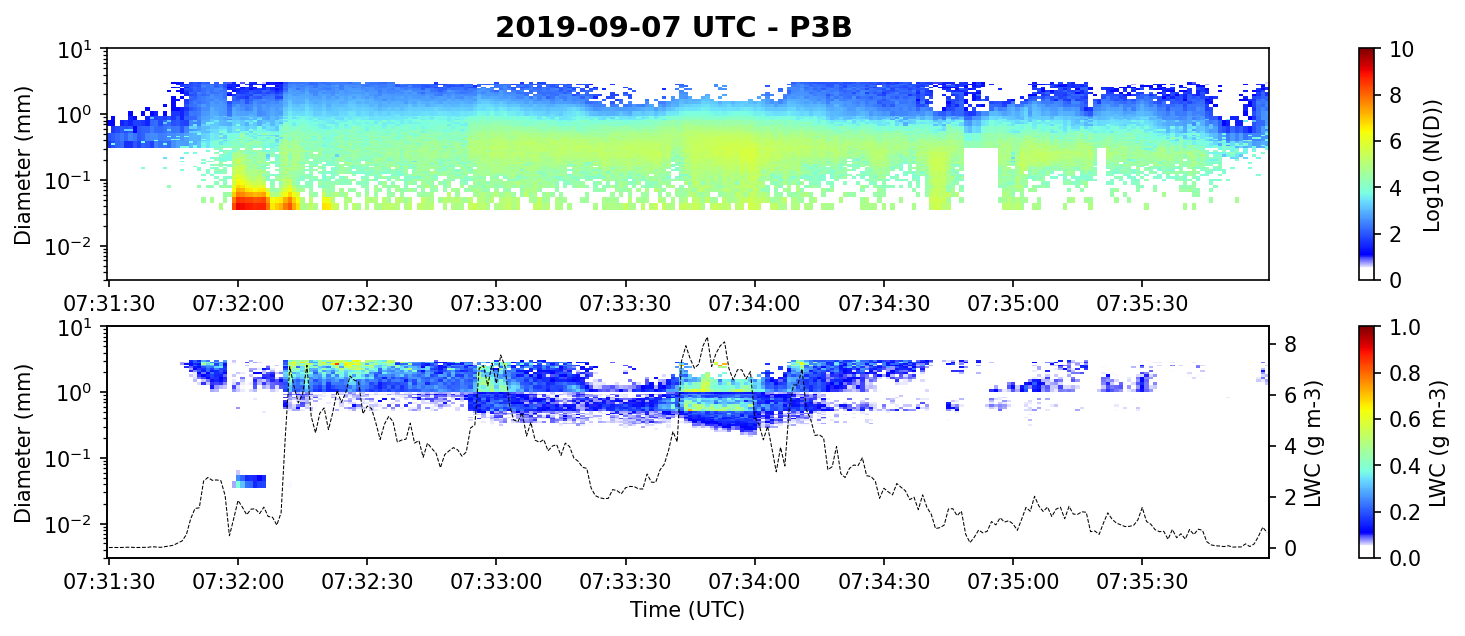

In [11]:
ds_comb = xr_comb_350.sel(time=slice('2019-09-07 07:31:30', '2019-09-07 07:35'))

lwc = pds_parameters(ds_comb).lwc

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 4.5), dpi=150)

cbar = ax0.pcolormesh(ds_comb.time, ds_comb.diameter/1e3, 
                      np.log10(ds_comb.psd.T * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap, shading='nearest')


cbar1 = ax1.pcolormesh(lwc.time, lwc.diameter / 1e3, 
                       lwc.T, 
                      vmin=0, vmax=1, cmap=my_cmap, shading='nearest')

ax11 = ax1.twinx()
lwc_sum = lwc.sum('diameter')    
ax11.plot(lwc_sum.time, lwc_sum, c='k', ls='--', lw=0.5)
ax11.plot()
add_colorbar_outside(cbar1, ax1, 'LWC (g m-3)')
add_colorbar_outside(cbar, ax0, 'Log10 (N(D))')
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Diameter (mm)')
ax11.set_ylabel('LWC (g m-3)')
ax0.set_ylabel('Diameter (mm)')

title = f"{pd.to_datetime(ds_comb.time.values[0]): %Y-%m-%d} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.93)
ax1.set_ylim(0.003, 10)
ax0.set_ylim(0.003, 10)
ax1.set_yscale('log')
ax0.set_yscale('log')

plt.show()

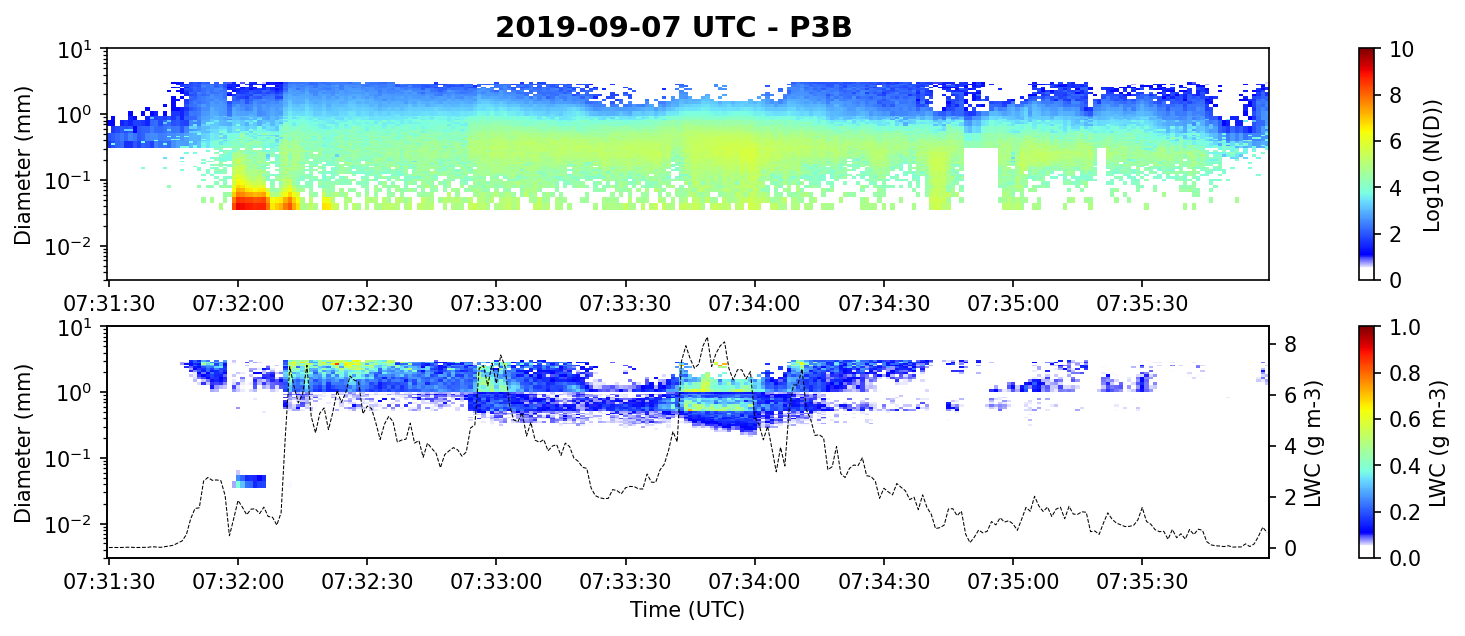

In [12]:
fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 4.5), dpi=150)

cbar = ax0.pcolormesh(ds_comb.time, ds_comb.diameter/1e3, 
                      np.log10(ds_comb.psd.T * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap, shading='nearest')


cbar1 = ax1.pcolormesh(lwc.time, lwc.diameter / 1e3, 
                       lwc.T, 
                      vmin=0, vmax=1, cmap=my_cmap, shading='nearest')

ax11 = ax1.twinx()
lwc_sum = lwc.sum('diameter')    
ax11.plot(lwc_sum.time, lwc_sum, c='k', ls='--', lw=0.5)
ax11.plot()
add_colorbar_outside(cbar1, ax1, 'LWC (g m-3)')
add_colorbar_outside(cbar, ax0, 'Log10 (N(D))')
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Diameter (mm)')
ax11.set_ylabel('LWC (g m-3)')
ax0.set_ylabel('Diameter (mm)')

title = f"{pd.to_datetime(ds_comb.time.values[0]): %Y-%m-%d} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.93)
ax1.set_ylim(0.003, 10)
ax0.set_ylim(0.003, 10)
ax1.set_yscale('log')
ax0.set_yscale('log')

plt.show()

In [13]:
# ds = pds_parameters(xr_comb_350).sel(time=slice('2019-09-07', '2019-09-10'))
ds = pds_parameters(xr_comb_350)
df = ds.to_dataframe().dropna()
df = df.dropna()

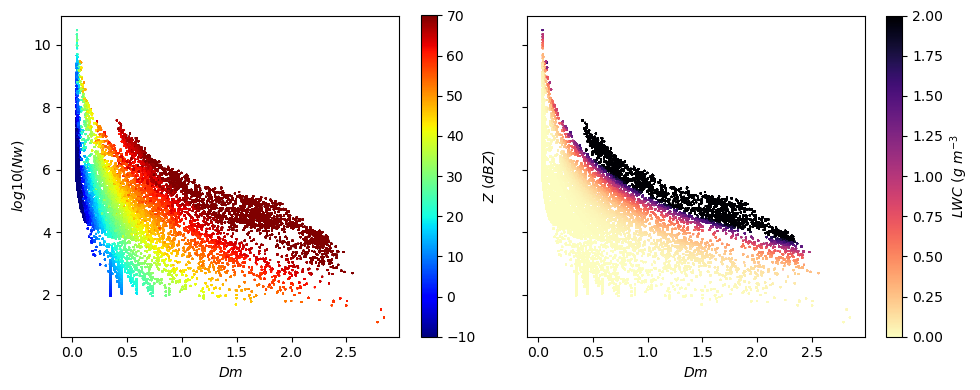

In [14]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(10, 4), sharey=True)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['dbz_t'], cmap='jet', vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Z \ (dBZ)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')

sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=2, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_xlabel(r'$Dm$')
plt.tight_layout()
plt.show()

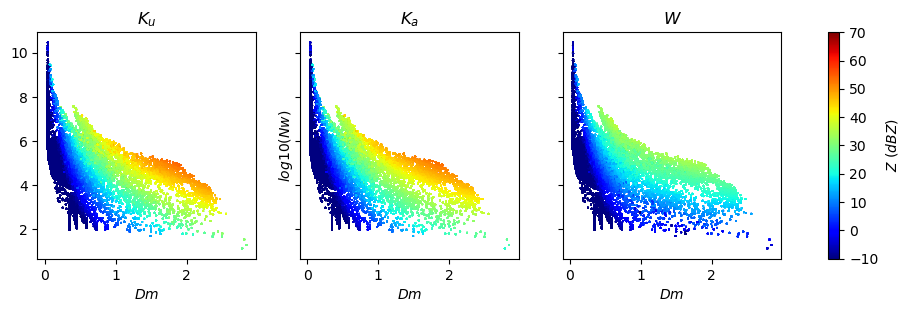

In [15]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, dpi=100, figsize=(12, 3), sharey=True)
sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_ka'], cmap='jet', vmin=-10, vmax=70, s=0.1)
# fig.colorbar(sc, ax=ax, label=r'$Z_{Ka} \ (dBZ)$')
ax1.set_xlabel(r'$Dm$')
ax1.set_title(r"$K_a$")
ax1.set_ylabel(r'$log10(Nw)$')

sc1 = ax.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_ku'], cmap='jet', vmin=-10, vmax=70, s=0.1)
# fig.colorbar(sc1, ax=ax1, label=r'$Z_{Ku} \ (dBZ)$')
ax.set_title(r"$K_u$")
ax.set_xlabel(r'$Dm$')

sc2 = ax2.scatter(df['dm'], df['log10_nw'], c=df['dbz_t_w'], cmap='jet', vmin=-10, vmax=70, s=0.1)
fig.colorbar(sc2, ax=[ax, ax1, ax2], label=r'$Z \ (dBZ)$')
ax2.set_xlabel(r'$Dm$')
ax2.set_title(r"$W$")
# plt.tight_layout()
plt.show()

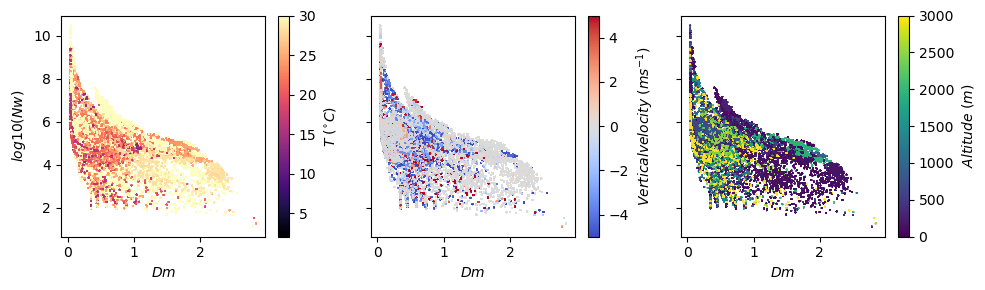

In [16]:
fig, (ax, ax1, ax2) = plt.subplots(1,3, dpi=100, figsize=(10, 3), sharey=True)
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['temp'], cmap='magma', vmin=2, vmax=30, s=0.01)
fig.colorbar(sc, ax=ax, label=r'$T \ (^{\circ}C)$')
ax.set_xlabel(r'$Dm$')
ax.set_ylabel(r'$log10(Nw)$')

sc = ax1.scatter(df['dm'], df['log10_nw'], c=df['vert_vel'], cmap='coolwarm', vmin=-5, vmax=5, s=0.01)
fig.colorbar(sc, ax=ax1, label=r'$Vertical velocity \ (ms^{-1})$')
ax1.set_xlabel(r'$Dm$')

sc = ax2.scatter(df['dm'], df['log10_nw'], c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.01)
fig.colorbar(sc, ax=ax2, label=r'$Altitude \ (m)$')
ax2.set_xlabel(r'$Dm$')

plt.tight_layout()
plt.show()

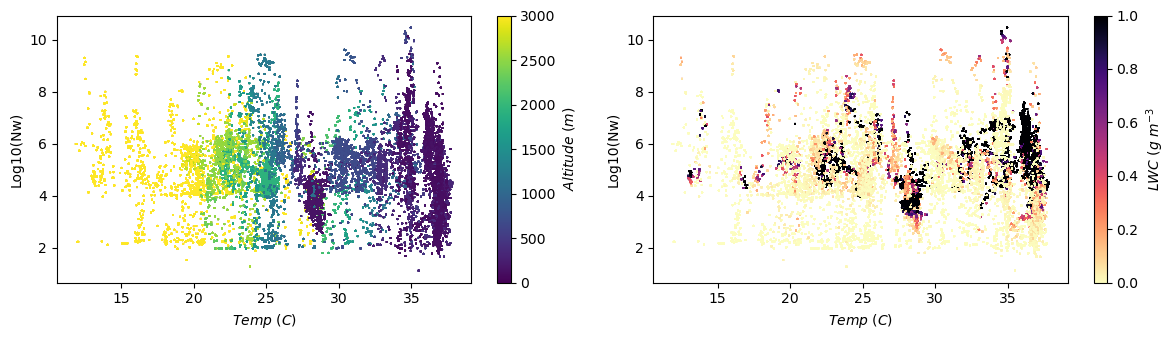

In [17]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['temp'], df['log10_nw'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Log10(Nw)')
ax.set_xlabel(r'$Temp \ (C)$')

sc = ax1.scatter(df['temp'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Log10(Nw)')
ax1.set_xlabel(r'$Temp \ (C)$')
plt.tight_layout()
plt.show()

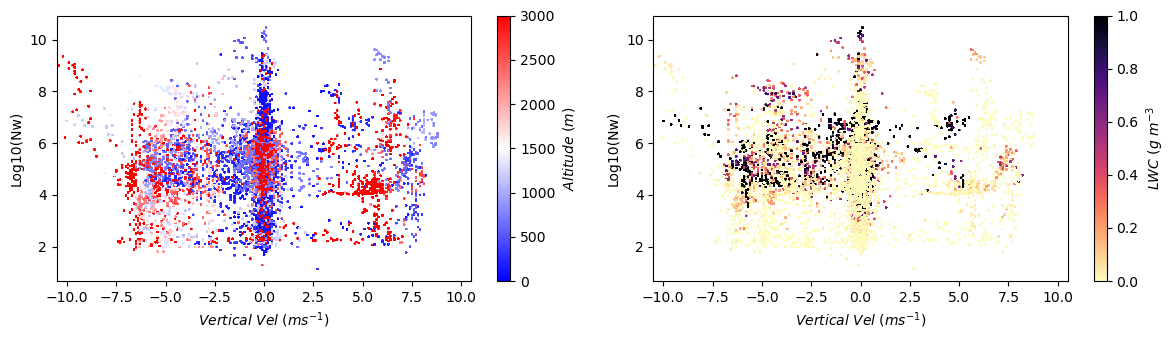

In [18]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['vert_vel'], df['log10_nw'],  c=df['altitude'], cmap='bwr', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Log10(Nw)')
ax.set_xlim(-10.5, 10.5)
ax.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')

sc = ax1.scatter(df['vert_vel'], df['log10_nw'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Log10(Nw)')
ax1.set_xlim(-10.5, 10.5)
ax1.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')
plt.tight_layout()
plt.show()

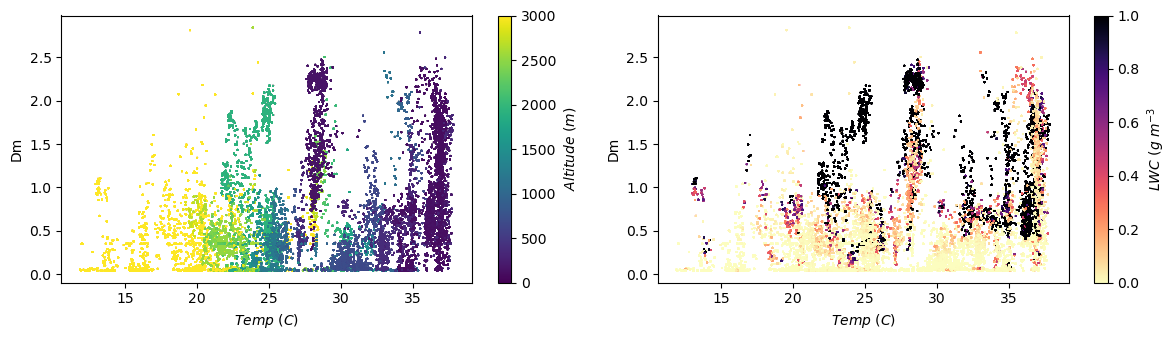

In [19]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['temp'], df['dm'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Dm')
ax.set_xlabel(r'$Temp \ (C)$')

sc = ax1.scatter(df['temp'], df['dm'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Dm')
ax1.set_xlabel(r'$Temp \ (C)$')
plt.tight_layout()
plt.show()

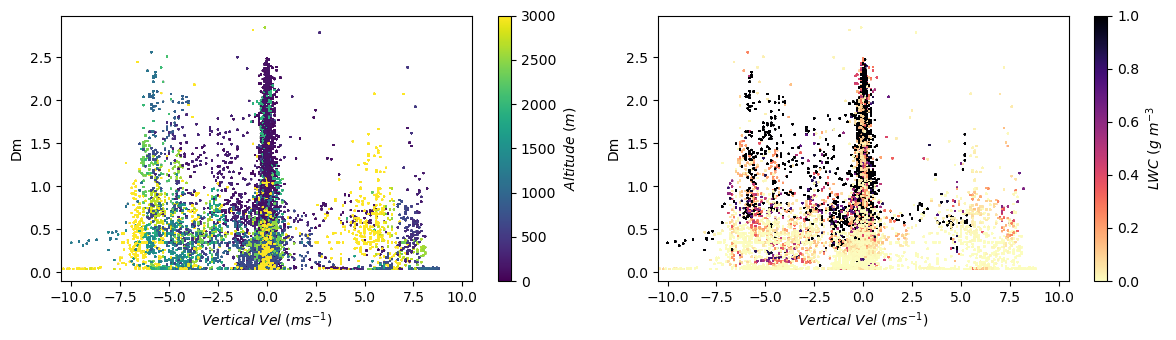

In [20]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['vert_vel'], df['dm'],  c=df['altitude'], cmap='viridis', vmin=0, vmax=3000, s=0.1)
fig.colorbar(sc, ax=ax, label=r'$Altitude \ (m)$')
ax.set_ylabel('Dm')
ax.set_xlim(-10.5, 10.5)
ax.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')

sc = ax1.scatter(df['vert_vel'], df['dm'], c=df['lwc_cum'], cmap='magma_r', vmin=0, vmax=1, s=0.1)
fig.colorbar(sc, ax=ax1, label=r'$LWC \ (g\  m^{-3}$')
ax1.set_ylabel('Dm')
ax1.set_xlim(-10.5, 10.5)
ax1.set_xlabel(r'$Vertical \ Vel \ (m s^{-1})$')
plt.tight_layout()
plt.show()

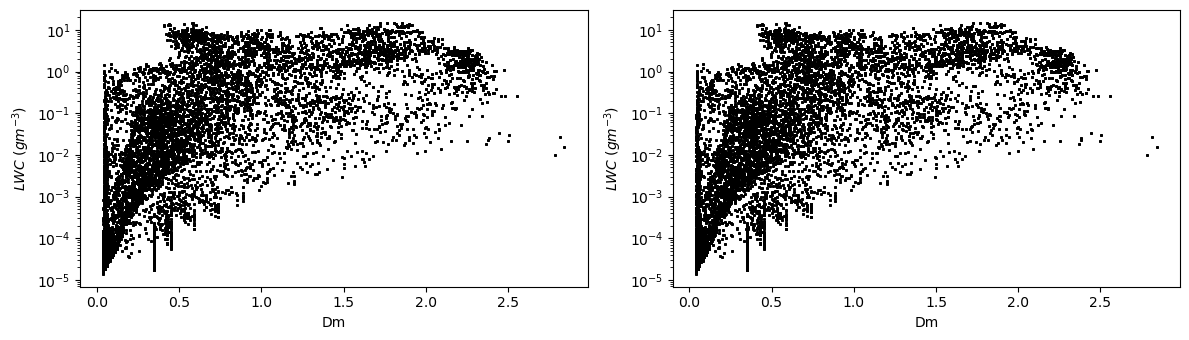

In [21]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sc = ax.scatter(df['dm'], df['lwc_cum'],  s=0.1 , c='k')
ax.set_yscale('log')
ax.set_xlabel('Dm')
ax1.set_ylabel(r'$LWC \ (gm^{-3})$')

sc = ax1.scatter( df['dm'], df['lwc_cum'], s=0.1, c='k')
ax1.set_yscale('log')
ax1.set_xlabel('Dm')
ax.set_ylabel(r'$LWC \ (gm^{-3})$')
plt.tight_layout()
plt.show()

In [22]:
class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

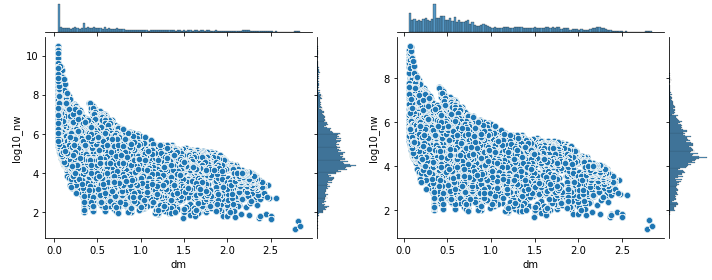

In [23]:
df_sub = df[(df['dm'] > 0.06)]

g0 = sns.jointplot(data=df, x="dm", y='log10_nw', cmap='magma')
g1 = sns.jointplot(data=df_sub, x="dm", y='log10_nw', cmap='magma')
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
plt.tight_layout()

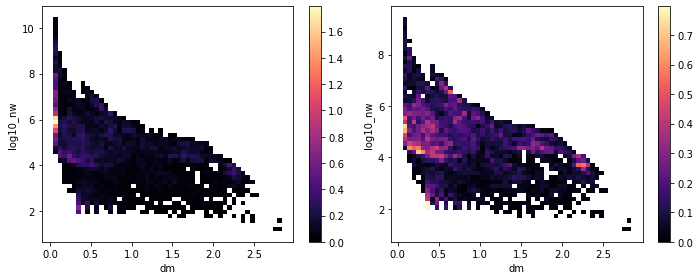

In [24]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
g2 = sns.histplot(data=df, x="dm", y='log10_nw', bins=(50, 50), cmap='magma', 
                     cbar=True, stat='density', ax=ax)
g3 = sns.histplot(data=df_sub, x="dm", y='log10_nw', bins=(50, 50), cmap='magma', 
                     cbar=True, stat='density', ax=ax1)
plt.tight_layout()

In [25]:
times = df[(df['dm'] <= 0.06)].index.get_level_values(0).unique()

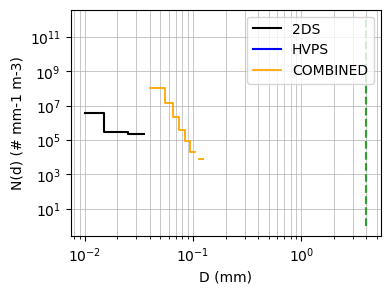

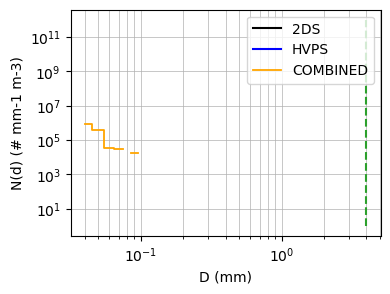

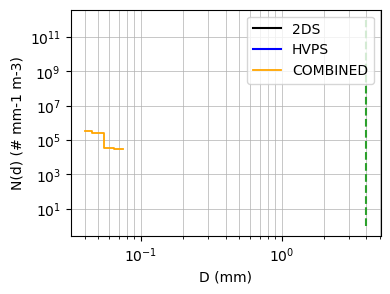

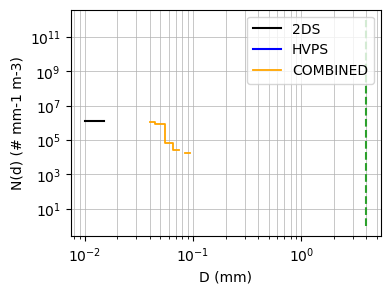

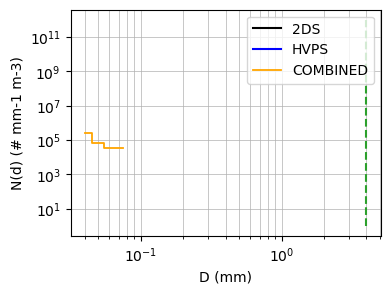

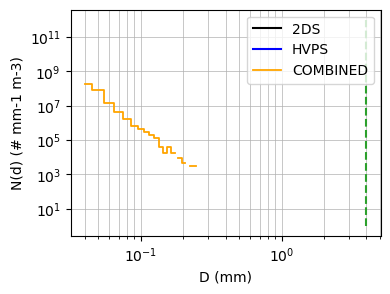

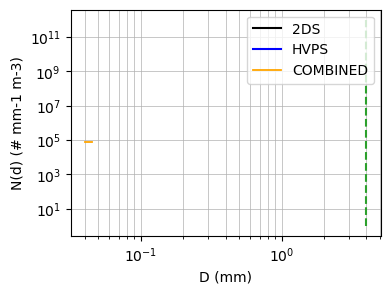

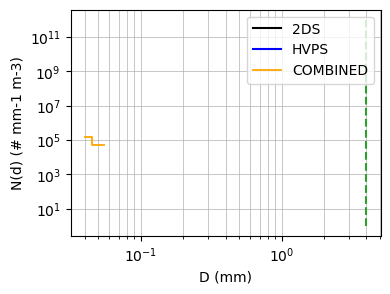

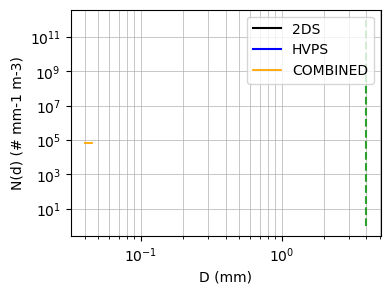

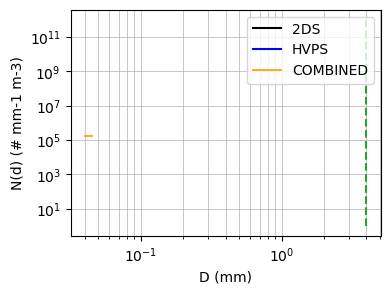

In [26]:
import random
_times = random.choices(times, k=10)
for i in _times:
    i = i.strftime('%Y-%m-%d %X') 
    fig, ax = plt.subplots(figsize=(4, 3), dpi=100)   
    try:
        y = xr_2ds.psd.sel(time=i) * 1e6
        y = y.where(y > 0, np.nan)
        ax.step(x=xr_2ds.diameter * 1e-3, y=y, where='mid', label='2DS', c='k')
    except KeyError:
        pass

    try:
        y = xr_hvps.psd.sel(time=i) * 1e6
        y = y.where(y > 0, np.nan)
        ax.step(x=xr_hvps.diameter* 1e-3, y=y, where='mid', label='HVPS', c='b')
    except:
        pass
    
    try:
        y = xr_comb_350.psd.sel(time=i).sel(diameter=slice(0.002, 4000)) * 1e6
        y = y.where(y > 0, np.nan)
        ax.step(x=y.diameter * 1e-3, y=y, where='mid', label='COMBINED', c='orange', lw=1.3)
    except (KeyError, NameError):
        pass
    
    ax.vlines(x=4000 * 1e-3, ymin=1e0, ymax=1e12, colors='C2', linestyles='dashed')
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(which='both', lw=0.5)
    ax.set_ylabel('N(d) (# mm-1 m-3)')
    ax.set_xlabel('D (mm)')
    ax.legend()
    plt.show()

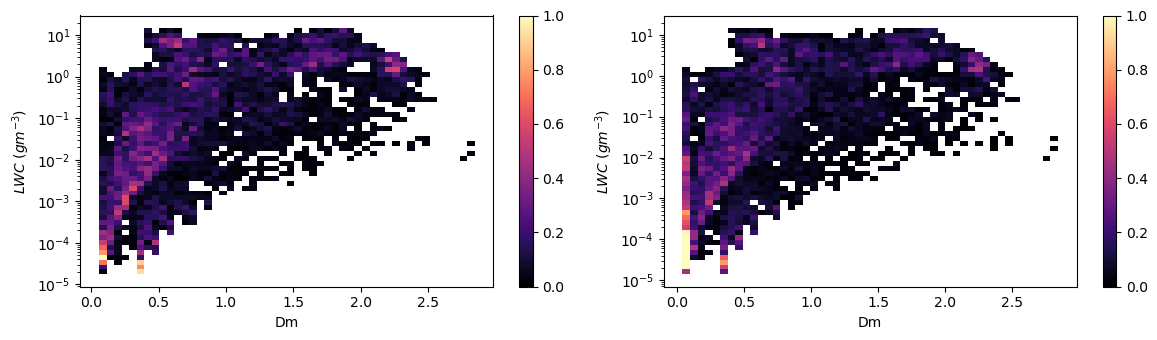

In [27]:
fig, (ax, ax1) = plt.subplots(1, 2, dpi=100, figsize=(12, 3.5))
sns.histplot(data=df_sub, x="dm", y='lwc_cum', bins=(50, 50), cmap='magma', ax=ax, cbar=True,\
             log_scale=(False, True), stat='density', vmin=0, vmax=1)
ax.set_xlabel('Dm')
ax1.set_ylabel(r'$LWC \ (gm^{-3})$')

sns.histplot(data=df, x="dm", y='lwc_cum', bins=(50, 50), cmap='magma', ax=ax1, cbar=True,\
             log_scale=(False, True), stat='density', vmin=0, vmax=1)
ax1.set_yscale('log')
ax1.set_xlabel('Dm')
ax.set_ylabel(r'$LWC \ (gm^{-3})$')
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='lwc_cum', ylabel='Count'>

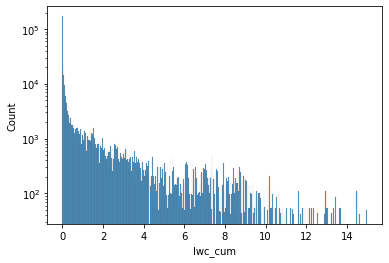

In [28]:
fig, ax = plt.subplots()
sns.histplot(data=df, x="lwc_cum",  ax=ax, log_scale=(False, True))

In [29]:
df[df['lwc_cum'] > 10].index.get_level_values(0).unique()

DatetimeIndex(['2019-09-07 07:42:35', '2019-09-07 07:42:37',
               '2019-09-07 07:42:38', '2019-09-07 07:42:39',
               '2019-09-07 07:42:40', '2019-09-07 07:42:41',
               '2019-09-07 07:42:42', '2019-09-07 07:42:43',
               '2019-09-07 07:42:44', '2019-09-07 07:42:45',
               '2019-09-07 07:42:48', '2019-09-07 07:42:49',
               '2019-09-07 07:42:50', '2019-09-07 07:42:51',
               '2019-09-07 07:42:52', '2019-09-07 07:42:53',
               '2019-09-07 07:42:54', '2019-09-07 07:42:55',
               '2019-09-07 07:42:56', '2019-09-07 07:42:57',
               '2019-09-07 07:42:58', '2019-09-07 07:42:59',
               '2019-09-07 07:43:00', '2019-09-07 07:43:01',
               '2019-09-07 07:43:08', '2019-09-07 07:43:09',
               '2019-09-07 07:43:10', '2019-09-07 07:43:11',
               '2019-09-07 07:43:12', '2019-09-07 07:43:13',
               '2019-09-09 03:56:07', '2019-09-09 03:56:08',
               '2019-09-

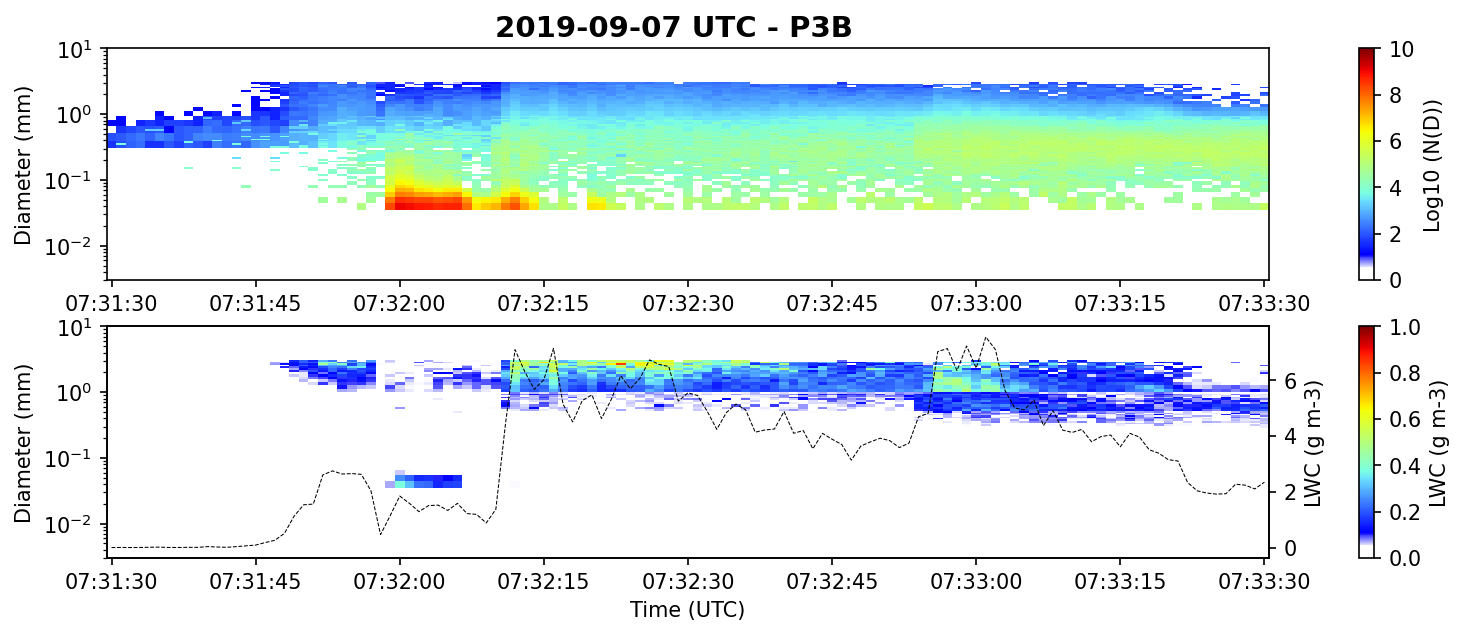

In [30]:
ds_comb = xr_comb_350.sel(time=slice('2019-09-07 07:31:30', '2019-09-07 07:33:30'))

lwc = pds_parameters(ds_comb).lwc

fig, (ax0, ax1) = plt.subplots(2,1, figsize=(10, 4.5), dpi=150)

cbar = ax0.pcolormesh(ds_comb.time, ds_comb.diameter/1e3, 
                      np.log10(ds_comb.psd.T * 1e6), 
                      vmin=0, vmax=10, cmap=my_cmap, shading='nearest')


cbar1 = ax1.pcolormesh(lwc.time, lwc.diameter / 1e3, 
                       lwc.T, 
                      vmin=0, vmax=1, cmap=my_cmap, shading='nearest')

ax11 = ax1.twinx()
lwc_sum = lwc.sum('diameter')    
ax11.plot(lwc_sum.time, lwc_sum, c='k', ls='--', lw=0.5)
ax11.plot()
add_colorbar_outside(cbar1, ax1, 'LWC (g m-3)')
add_colorbar_outside(cbar, ax0, 'Log10 (N(D))')
ax1.set_xlabel('Time (UTC)')
ax1.set_ylabel('Diameter (mm)')
ax11.set_ylabel('LWC (g m-3)')
ax0.set_ylabel('Diameter (mm)')

title = f"{pd.to_datetime(ds_comb.time.values[0]): %Y-%m-%d} UTC - {aircraft}"
fig.suptitle(title, fontsize=14, fontweight='bold', y=0.93)
ax1.set_ylim(0.003, 10)
ax0.set_ylim(0.003, 10)
ax1.set_yscale('log')
ax0.set_yscale('log')

plt.show()